In [482]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [483]:
import pandas as pd
import numpy as np
import json
import os
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# NOTE: This notebook must be run in chronological order and some cells may NOT be re-run

# Loading and Dropping Duplicates

In [484]:
# Paths
RAW_FOLDER = './data/raw/'
ANIME_FILE = 'animes.csv'
PROFILES_FILE = 'profiles.csv'
REVIEWS_FILE = 'reviews.csv'

In [485]:
anime = pd.read_csv(os.path.join(RAW_FOLDER, ANIME_FILE))
users = pd.read_csv(os.path.join(RAW_FOLDER, PROFILES_FILE))
reviews = pd.read_csv(os.path.join(RAW_FOLDER, REVIEWS_FILE))

In [486]:
anime = anime.drop_duplicates(subset=['uid'])
users = users.drop_duplicates(subset=['profile'])
reviews = reviews.drop_duplicates(subset=['uid'])

In [487]:
# Raw Dataset Statistics
print(f"# Anime: {len(anime)}")
print(f"# Users: {len(users)}")
print(f"# Reviews: {len(reviews)}")
assert len(users['profile'].unique()) == len(reviews['profile'].unique())

# Anime: 16216
# Users: 47885
# Reviews: 130519


# Processing

## Removing Irrelevant Columns

In [488]:
anime = anime[['uid', 'title', 'synopsis', 'genre', 'score']]

In [489]:
reviews = reviews[['uid', 'profile', 'anime_uid', 'text', 'score']]

## Renaming Columns for Clarity

In [490]:
anime = anime.rename(columns={'uid': 'item_id'})
anime.head()

,item_id,title,synopsis,genre,score
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",8.83
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",9.23
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",8.83


In [491]:
reviews = reviews.rename(columns={'uid': 'review_id', 'profile': 'user_id', 'anime_uid': 'item_id', 'score': 'rating'})
reviews.head()

,review_id,user_id,item_id,text,rating
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8
1,259117,baekbeans,34599,\n \n \n \n ...,10
2,253664,skrn,28891,\n \n \n \n ...,7
3,8254,edgewalker00,2904,\n \n \n \n ...,9
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10


## Reducing Our Dataset

Recommendation systems typically struggle with sparse datasets, and our dataset is **very** sparse.

We apply a standard filter of only items with > 10 reviews. Then, we apply another filter on top for only users with > 10 reviews.

In [492]:
# Flags to ensure cell runs once
filtered_items = False
filtered_users = False

## Keep items with >= 10 reviews

In [493]:
if not filtered_users and not filtered_items:
    anime_counts = Counter(reviews['item_id'])
    selected_anime = {k: v for k,v in anime_counts.items() if v >= 10}
    reviews = reviews[reviews['item_id'].isin(selected_anime)]
    filtered_items = True
    print(f"# of reviews after filtering by item counts >= 10: {len(reviews)}")
elif not filtered_users and filtered_items:
    print("You somehow filtered items first, please reload data")
else:
    print("You're done filtering")
    print(f"# of reviews: {len(reviews)}")

# of reviews after filtering by item counts >= 10: 113874


## Keep users with >= 10 reviews

In [494]:
if filtered_items and not filtered_users:
    user_counts = Counter(reviews['user_id'])
    selected_users = {k: v for k,v in user_counts.items() if v >= 10}
    reviews = reviews[reviews['user_id'].isin(selected_users)]
    filtered_users = True
    print(f"# of reviews after further filtering by user counts >= 10: {len(users)}")
elif not filtered_items:
    print("Filter items first")
else:
    print("You're done filtering.")
    print(f"# of reviews: {len(reviews)}")

# of reviews after further filtering by user counts >= 10: 47885


## Remove items that have no reviews

In [495]:
anime = anime[anime['item_id'].isin(set(reviews['item_id']))]

## Re-examining Distributions

In [496]:
anime_counts = Counter(reviews['item_id']).values()

Mean Reviews per Anime: 15.771479185119574
Median Reviews per Anime: 10


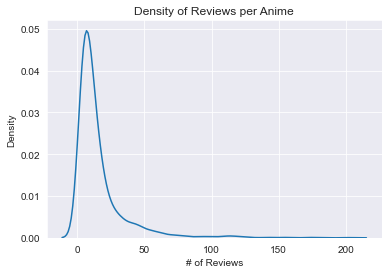

In [497]:
p = sns.kdeplot(anime_counts)
p.set(xlabel="# of Reviews", ylabel="Density", title="Density of Reviews per Anime")
print(f"Mean Reviews per Anime: {sum(anime_counts) / len(anime_counts)}")
print(f"Median Reviews per Anime: {sorted(anime_counts)[len(anime_counts)//2]}")

In [498]:
user_counts = Counter(reviews['user_id']).values()

Mean Reviews per User: 23.29103989535644
Median Reviews per User: 15


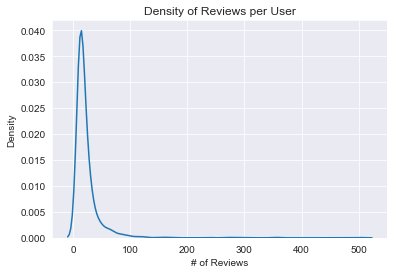

In [499]:
p = sns.kdeplot(user_counts)
p.set(xlabel="# of Reviews", ylabel="Density", title="Density of Reviews per User")
print(f"Mean Reviews per User: {sum(user_counts) / len(user_counts)}")
print(f"Median Reviews per User: {sorted(user_counts)[len(user_counts)//2]}")

In [500]:
# TODO: Insert overlayed distribution here (before and after processing)

## Cleaning reviews to remove MAL artifacts that were collected by scraper

In [501]:
end_of_scores_marker = "\n         \n       \n     \n\n                    \n    "
reviews['text'] = reviews['text'].apply(lambda x: x[x.index(end_of_scores_marker) + len(end_of_scores_marker):])

In [502]:
end_of_review_marker = "\n\n          \n \n       Helpful \n   \n      "
reviews['text'] = reviews['text'].apply(lambda x: x[:x.index(end_of_review_marker)])

In [503]:
reviews.head()

,review_id,user_id,item_id,text,rating
0,255938,DesolatePsyche,34096,"First things first. My ""reviews"" system is exp...",8
1,259117,baekbeans,34599,Let me start off by saying that Made in Abyss ...,10
2,253664,skrn,28891,"Art 9/10: It is great, especially the actions ...",7
6,247454,Waffle_Empress,16664,As someone who loves Studio Ghibli and its mov...,6
8,23791,jchang,2904,code geass is one of those series that everybo...,10


## Re-indexing user and item ids

In [504]:
username_to_idx = {}
item_id_to_idx = {}
for _, row in reviews.iterrows():
    username, item_id = row.user_id, row.item_id
    if username not in username_to_idx:
        username_to_idx[username] = len(username_to_idx)
    if item_id not in item_id_to_idx:
        item_id_to_idx[item_id] = 1 + len(item_id_to_idx)
assert len(username_to_idx) == reviews['user_id'].nunique()
assert len(item_id_to_idx) == reviews['item_id'].nunique()

In [505]:
reviews['user_id'] = reviews['user_id'].apply(lambda x: username_to_idx[x])
reviews['item_id'] = reviews['item_id'].apply(lambda x: item_id_to_idx[x])

In [506]:
anime['item_id'] = anime['item_id'].apply(lambda x: item_id_to_idx[x])
assert len(anime) == reviews['item_id'].nunique()

## Applying tokenization to text

In [507]:
reviews['tokenized_text'] = reviews['text'].apply(lambda doc: [word_tokenize(sent) for sent in sent_tokenize(doc)])

In [508]:
reviews.head()

,review_id,user_id,item_id,text,rating,tokenized_text
0,255938,0,1,"First things first. My ""reviews"" system is exp...",8,"[[First, things, first, .], [My, ``, reviews, ..."
1,259117,1,2,Let me start off by saying that Made in Abyss ...,10,"[[Let, me, start, off, by, saying, that, Made,..."
2,253664,2,3,"Art 9/10: It is great, especially the actions ...",7,"[[Art, 9/10, :, It, is, great, ,, especially, ..."
6,247454,3,4,As someone who loves Studio Ghibli and its mov...,6,"[[As, someone, who, loves, Studio, Ghibli, and..."
8,23791,4,5,code geass is one of those series that everybo...,10,"[[code, geass, is, one, of, those, series, tha..."


## Cleaning and tokenizing synopsis

In [509]:
end_of_synopsis_marker = " \r\n \r\n[Written by MAL Rewrite]"

In [563]:
def remove_artifact(x):
    if end_of_synopsis_marker not in x:
        return x
    return x[:x.index(end_of_synopsis_marker)]

def strip_extra_quotes(x):
    return x.strip('"')

In [564]:
anime['synopsis'] = anime['synopsis'].fillna('')
anime['synopsis'] = anime['synopsis'].apply(lambda x: remove_artifact(x))
anime['synopsis'] = anime['synopsis'].apply(lambda x: strip_extra_quotes(x))

In [565]:
anime['tokenized_synopsis'] = anime['synopsis'].apply(lambda sent: word_tokenize(sent))

# Saving

In [566]:
# Paths
PROCESSED_FOLDER = './data/processed/'
PROCESSED_ANIME_FILE = 'processed_animes.csv'
PROCESSED_REVIEWS_FILE = 'processed_reviews.csv'

In [604]:
anime.to_csv(os.path.join(PROCESSED_FOLDER, PROCESSED_ANIME_FILE), index=False)
reviews.to_csv(os.path.join(PROCESSED_FOLDER, PROCESSED_REVIEWS_FILE), index=False)

In [605]:
test_reviews = pd.read_csv(os.path.join(PROCESSED_FOLDER, PROCESSED_REVIEWS_FILE))

In [606]:
test_reviews

,review_id,user_id,item_id,text,rating,tokenized_text
0,255938,0,1,"First things first. My ""reviews"" system is exp...",8,"[['First', 'things', 'first', '.'], ['My', '``..."
1,259117,1,2,Let me start off by saying that Made in Abyss ...,10,"[['Let', 'me', 'start', 'off', 'by', 'saying',..."
2,253664,2,3,"Art 9/10: It is great, especially the actions ...",7,"[['Art', '9/10', ':', 'It', 'is', 'great', ','..."
3,247454,3,4,As someone who loves Studio Ghibli and its mov...,6,"[['As', 'someone', 'who', 'loves', 'Studio', '..."
4,23791,4,5,code geass is one of those series that everybo...,10,"[['code', 'geass', 'is', 'one', 'of', 'those',..."
...,...,...,...,...,...,...
35607,7847,501,818,Before I start let me just say that I went int...,8,"[['Before', 'I', 'start', 'let', 'me', 'just',..."
35608,52643,699,818,The first movie in a series of unexpected cand...,8,"[['The', 'first', 'movie', 'in', 'a', 'series'..."
35609,165807,502,818,kara no kyoikai 1:fukan fuukei is a first inst...,9,"[['kara', 'no', 'kyoikai', '1', ':', 'fukan', ..."
35610,72705,13,818,The Kara no Kyoukai or Garden of Sinners films...,8,"[['The', 'Kara', 'no', 'Kyoukai', 'or', 'Garde..."
